# Reading Recipes with spaCy for Named Entity Recognition (NER)

## Installing and Using spaCy
Sometimes getting spaCy installed correctly is a bit of a challenge.
It's good to check that the expected versions and packages are recognized before writing any code.
If you don't have spaCy installed, the [spaCy 101: Everything you need to know](https://spacy.io/usage) guide has an interactive tool that will generate the commands you need to run.
Make sure to select your operating system and package manager of choice, then enable `train_models` and select `accuracy`.
We are going to use the CPU for now, because training spaCy models on a GPU involves large transformers that require >10GB of graphics RAM.

In [25]:
'''
Validate spacy installs, compatability for version used
'''
!python -m spacy validate
import spacy


⠙ Loading compatibility table...
⠹ Loading compatibility table...
⠸ Loading compatibility table...
⠼ Loading compatibility table...
⠴ Loading compatibility table...
⠦ Loading compatibility table...
⠧ Loading compatibility table...
⠇ Loading compatibility table...
⠏ Loading compatibility table...
⠙ Loading compatibility table...
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.1.3) =================
ℹ spaCy installation:
C:\Users\elvis\anaconda3\envs\jupyter\lib\site-packages\spacy

NAME              SPACY            VERSION    
en_core_web_lg    >=3.1.0,<3.2.0   3.1.0     ✔
en_core_web_sm    >=3.1.0,<3.2.0   3.1.0     ✔
en_core_web_trf   >=3.1.0,<3.2.0   3.1.0     ✔



The following cell disables an optimization for Intel processors that can cause the jupyter kernel to crash.
You can skip this and only run it if you encounter crashes while training.

In [26]:
'''
During training the Jupyter kernel crashes without this set
it has to do with a Intel specifc optimization that sometimes
doesn't play well with certain versions of things
'''
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## spaCy Demo: NER and Visualization Basics
Here, we are trying to see how we can get spaCy to perform NER.
First, let's see what the base NER can do, and visualize it nicely with `displacy`.

Here, let's use a two-sentence text, and run the entity labeler based on the small English model and the large English model.
From this, we can learn a few things about these spaCy models and how we may create our own.

In [27]:
# Text taken from Sonic Wikipedia page
texts = [
    "Sonic the Hedgehog is a Japanese video game series and media franchise created and owned by Sega.",
    "The franchise follows Sonic, an anthropomorphic blue hedgehog who battles the evil Doctor Eggman, a mad scientist.",
]

# Example using small English pre-trained model
print("Small Model:")
nlp = spacy.load("en_core_web_sm")
for doc in nlp.pipe(texts, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
    # Do something with the doc here
    print([(ent.text, ent.label_) for ent in doc.ents])

# Example using large English pre-trained model
print("Large Model:")
nlp = spacy.load("en_core_web_lg")
for doc in nlp.pipe(texts, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
    # Do something with the doc here
    print([(ent.text, ent.label_) for ent in doc.ents])

Small Model:
[('Hedgehog', 'PRODUCT'), ('Japanese', 'NORP'), ('Sega', 'PERSON')]
[('Sonic', 'ORG'), ('Eggman', 'PERSON')]
Large Model:
[('Japanese', 'NORP'), ('Sega', 'ORG')]
[('Sonic', 'ORG'), ('Eggman', 'PERSON')]


From the start, we see some issues the way that entities are found and labeled. 
Using the **small English model**, it says that *Hedgehog* in this case is a PRODUCT, *Sega* is a PERSON rather than an ORG, and *Sonic* is an ORG when it is referring to the character. 
The **large English model**, however, correctly labels *Sega* as an ORG, and does not label *Hedgehog* as a PRODUCT.
We can see the possible reasoning for *Sonic* to still be mislabeled, as *Sonic* also refers to the fast-food chain, and the model may have been trained based on that.

With these two comparisons, we can see how creating a large training model will be very, very important for this project to work well!

Next, let's create some pretty graphics representing the entity labeling using `displacy`!
We're going to use a new, short sentence.

In [28]:
'''
Example with Visualizations
'''
from spacy import displacy

nlp = spacy.load("en_core_web_lg")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

# just like with anti-trust law, lets give apple some special treatment
colors = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}
doc.user_data["title"] = "Example Render of Entity Recognizer"
displacy.render(doc, style="ent", jupyter=True, options=options)

Wow!
Not only does it look great, we can see how well spaCy can perform when the data is similar to what the model was trained on.
We'll end up with our own model that works just as well - except it can read recipes.

# Create Training Data
After we did some smaller tests to see how spaCy is working, let's compile the datasets into valuable training data to train our own model.
This will then be used in order to create everything we need to deal with new data.
We're doing this with the **recipe** text we want to eventually use!

### Step 1: See What Spacy Already Labels
First, let's see how it works with text from a recipe.
This will help us know how to build our model and how to format our dataset.
With this, we can see what entities spaCy looks for when given a recipe.

In [29]:
'''
Example using Recipe Text
'''
test = "add flour and stir to cook and absorb the oil, then add in 1 cup vegan\
        creamer or plant milk and vegan chicken bouillon paste/powder/cube, then whisk/stir\
        vigorously until the flour has cooked and thickened in the sauce (to make the roux).\
         add the grated vegan parm and stir to melt, then thin the sauce with either more\
        plant milk or the reserved cooking pasta water."
nlp = spacy.load("en_core_web_lg")
doc = nlp(test)
for ent in doc.ents:
    print(ent.text, ent.label_)

1 CARDINAL


Things are looking too good for our budding AI chef.
It seems that spaCy is only able to pick out cardinals from our sample text.
That's fine! 
In the next step, we're going to look on how to create connected entities and labels, the first step for creating the dataset we need.

### Step 2: Build a Small Training Dataset Example

We want to build our dataset to be able to detect three things: **ingredients**, **quantities**, and **processes**.
And, we are able to do just that. 
Let's manually do that now with the example above, but start off with a blank spacy nlp, so that labels such as cardinals are disregarded
 Without doing this, **quantities** that include numbers will be labeled as cardinals instead.

Examples of each label:
* **Ingredients**: Flour, sugar, apple sauce...
* **Quantities**: 1 cup, 1/4 tablespoon, 1 teaspoon...
* **Processes**: Mix, stir, fry...

In [32]:
'''
Create and visualize training text and entities.
'''

# Retype test text to make sure indent spacing does not show up
test = "add flour and stir to cook and absorb the oil, then add in 1 cup vegan creamer or plant milk and vegan chicken bouillon paste/powder/cube, then whisk/stir vigorously until the flour has cooked and thickened in the sauce (to make the roux). add the grated vegan parm and stir to melt, then thin the sauce with either more plant milk or the reserved cooking pasta water."

# List of all entities in above example
patterns = [
                {"label": "INGREDIENT", "pattern": "flour"},
                {"label": "INGREDIENT", "pattern": "oil"},
                {"label": "INGREDIENT", "pattern": "vegan creamer"},
                {"label": "INGREDIENT", "pattern": "plant milk"},
                {"label": "INGREDIENT", "pattern": "vegan chicken bouillon"},
                {"label": "INGREDIENT", "pattern": "vegan parm"},
                {"label": "QUANTITY", "pattern": "1 cup"},
                {"label": "PROCESS", "pattern": "add"},
                {"label": "PROCESS", "pattern": "stir"},
                {"label": "PROCESS", "pattern": "whisk"},
                {"label": "PROCESS", "pattern": "thin"},
            ]

To start, we can create a blank spaCy model.
With just one line of code we have the powerful architecture of spaCy at our fingertips!
For now, our pipeline will consist of the `sentencizer` and `entity_ruler` to split the text into sentences and identify identities using the rules we just wrote.

In [ ]:
# Blank English-based spacy nlp
nlp = spacy.blank("en")

# Create the EntityRuler
ruler = nlp.add_pipe("entity_ruler") # entity ruler
nlp.add_pipe("sentencizer") # to split into sentences

Then, we can load our rules into the entity ruler for our pipeline.
Without this step, our pipeline will do nothing.

In [ ]:
ruler.add_patterns(patterns)

Then, we can feed data into our pipeline and see how it performs.

In [ ]:
# corpus is latin for body and is a fancy way of referring to our sentences
corpus = []
doc = nlp(test)
for sent in doc.sents:
    corpus.append(sent.text)

# Use print() to check this, but also visualized below
ents = [(ent.text,ent.label_) for ent in doc.ents]

# Make some pretty label colorings for each entity label
sentence_spans = list(doc.sents)
colors = {"INGREDIENT": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
          "PROCESS": "linear-gradient(90deg, #3fc9a2, #a2f7b5)",
          "QUANTITY": "linear-gradient(90deg, #787ff6, #4adede)"}
options = {"colors": colors}

# Render using displacy
displacy.render(sentence_spans, style="ent", jupyter=True, options=options)

We created our text, nlp, and additions to the *Entity Ruler*. Using `displacy` with a few custom color gradients makes it look quite nice, but also makes it super easy for the human eye to look at and pick out any issues.
Because it's a word-by-word basis, everything is correct!
However, if we try a new ingredient it won't be recognized.

In [33]:
test = "add 1 cup of water and 1 cup of flour"
corpus = []
doc = nlp(test)
for sent in doc.sents:
    corpus.append(sent.text)

# Use print() to check this, but also visualized below
ents = [(ent.text,ent.label_) for ent in doc.ents]

# Make some pretty label colorings for each entity label
sentence_spans = list(doc.sents)
colors = {"INGREDIENT": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
          "PROCESS": "linear-gradient(90deg, #3fc9a2, #a2f7b5)",
          "QUANTITY": "linear-gradient(90deg, #787ff6, #4adede)"}
options = {"colors": colors}

# Render using displacy
displacy.render(sentence_spans, style="ent", jupyter=True, options=options)

Next, we create a small dataset with this data.
Now, we aren't doing anything with these two sentences right now (although we will be scraping through the page that it's hosted on for it), but it should help us understand how spaCy training data are formatted and used.

The important insight here is that we can take unlabled data, write some rules and have spaCy label our data for us.
Although it won't be perfect if we miss some entities, it avoids what would otherwise be hundreds of hours of manual labeling.

In [6]:
'''
Create the example training data.
'''

TRAIN_DATA = [] # Empty data beforehand

# Iterate through sentences in body of data
for sentence in corpus:
    doc = nlp(sentence)
    entities = []
    # For every entity found...
    for ent in doc.ents:
        # Append locations labels of each entity in text
        entities.append([ent.start_char, ent.end_char, ent.label_])
    TRAIN_DATA.append([sentence, {"entities": entities}])

print("\n Train Data formatted for use of spaCy: \n")
print(TRAIN_DATA)


 Train Data formatted for use of spaCy: 

[['add flour and stir to cook and absorb the oil, then add in 1 cup vegan creamer or plant milk and vegan chicken bouillon paste/powder/cube, then whisk/stir vigorously until the flour has cooked and thickened in the sauce (to make the roux).', {'entities': [[0, 3, 'PROCESS'], [4, 9, 'INGREDIENT'], [14, 18, 'PROCESS'], [42, 45, 'INGREDIENT'], [52, 55, 'PROCESS'], [59, 64, 'QUANTITY'], [65, 78, 'INGREDIENT'], [82, 92, 'INGREDIENT'], [97, 119, 'INGREDIENT'], [144, 149, 'PROCESS'], [150, 154, 'PROCESS'], [176, 181, 'INGREDIENT']]}], ['add the grated vegan parm and stir to melt, then thin the sauce with either more plant milk or the reserved cooking pasta water.', {'entities': [[0, 3, 'PROCESS'], [15, 25, 'INGREDIENT'], [30, 34, 'PROCESS'], [49, 53, 'PROCESS'], [81, 91, 'INGREDIENT']]}]]


For each sentence we now have a tuple with the sentence text and the locations and entity types.
Using this, spaCy can build a model entirely based on an empty English model!
This is what we will use for our **Recipe NER**.

### Step 3: Build the Real Training Dataset

We can now see how we can create training data for spaCy to use.
Let's go ahead and make a real dataset.

In the **label_data** folder, we will create three *json* files: `processes.json`, `quantities.json`, and `ingredients.json`.

Just like before, we are starting by creating some data by hand. 
In some cases, we can programmatically generate hundreds of possible combinations. 
Other times, we will have to just build a list by hand.

In [34]:
'''
Functions for Reading and Writing JSON Files
'''

def load_data(file):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    return (data)

def write_data(file, data):
    with open(file, "w", encoding="utf-8") as f:
        json.dump(data, f)

In [35]:
'''
Create quantities
'''
import json

# create bases list for quantities
quantity_bases = ["tsp","teaspoon","tbsp","tablespoon","cup","pt","pint","qt","quart","gal","gallon","ml","milliliter","oz","ounce","g","gram"]
# add plural cases to list
quantity_bases = quantity_bases + [quantity_base+"s" for quantity_base in quantity_bases]
# we're combining these cases, because we never know when there'll be a typo :)

#print(quantity_bases)

# create a list of possible fractions to use
possible_fractions = ["1/2",
                      "1/3","2/3",
                      "1/4", "3/4",
                      "1/8", "5/8","7/8",
                      "1/16"]

# finally, complete the quantity list
quantities_list = []
frac_quantities_list = []
int_quantities_list = []
comb_quantities_list = []

LARGEST_INT_QUANTITY = 800
SMALLEST_INT_QUANTITY = 10

for quantity_base in quantity_bases:
  # into case of each int portion
  for i in range(LARGEST_INT_QUANTITY):
    int_quantity = f"{i+1} {quantity_base}"
    int_quantities_list.append(int_quantity)
  # into case of each fraction portion
  for frac in possible_fractions:
    portion_quantity = f"{frac} {quantity_base}"
    frac_quantities_list.append(portion_quantity)
    # add combined cases for each (ie 1 1/2 tsp)
    for i in range(SMALLEST_INT_QUANTITY):
      comb_quantity = f"{i+1} {frac} {quantity_base}"
      comb_quantities_list.append(comb_quantity)
# combine all cases
quantities_list.sort()
quantities_list = int_quantities_list+frac_quantities_list+comb_quantities_list

# add to json file
write_data('./label_data/quantities.json', quantities_list)


# Creating and Testing Training Data

In the tutorial for obtaining data, we were able to use a simple regular expression (another form of pattern matching) to identify many of the entities in the dataset we will be training on.
We can combine this with the lists we generated to create a very comprehensive set of patterns.

In [37]:
'''
Create training data
'''

def create_training_data(file, type):
  data = load_data(file)
  patterns = []
  for item in data:
    pattern = {
      "label": type,
      "pattern": item
    }
    patterns.append(pattern)
  return patterns


# Run it through the datasets that were created
processes_patterns = create_training_data("label_data/processes.json", "PROCESS")
quantities_patterns = create_training_data("label_data/quantities.json", "QUANTITY")
dataset_quantities_patterns = create_training_data("scraper/data/quantities.json", "QUANTITY")
dataset_ingredients_patterns = create_training_data("scraper/data/ingredients.json", "INGREDIENT")

# All patterns combined
all_patterns = processes_patterns + quantities_patterns + dataset_quantities_patterns + dataset_ingredients_patterns
len(all_patterns)

36285

## Generate EntityRules

We can use our list of over 36,000 patterns to create a powerful entity ruler that will label our dataset.

In [38]:
'''
Generate Rules in spaCy
'''

def generate_rules(patterns):
  # Blank English-based spacy nlp
  nlp = spacy.blank("en")
  # Create the EntityRuler
  ruler = nlp.add_pipe("entity_ruler") # entity ruler
  nlp.add_pipe("sentencizer") # to split into sentences
  ruler.add_patterns(patterns) # add patterns
  # Save spaCy files to disk
  nlp.to_disk("recipes_ner_ruler")

generate_rules(all_patterns)

## Test the model on example

Before we run the ruler on the thousands of recipes in our dataset, let's test it on an example to make sure it's working how we expect.


In [48]:
'''
Test the new model!
'''
def test_model(nlp, text):
  doc = nlp(text)
  results = []
  entities = []
  for ent in doc.ents:
    entities.append((ent.start_char, ent.end_char, ent.label_))
  if len(entities) > 0:
    results = [text, {"entities":entities}]
    return [results, doc]

# load the model we saved
nlp = spacy.load("recipes_ner_ruler")

test = "prepare the cauliflower and seasoning salt. first, cut the cauliflower in half and cut out bite-sized florets. in a large bowl, mix together the garlic salt, paprika/cayenne pepper, white pepper, ground ginger, soy sauce, and oat milk. toss the cauliflower florets in the oat milk mixture. cover the bowl with a plastic wrap, and let chill in the refrigerator for an hour. meanwhile, prepare the seasoning salt by mixing together all the seasoning salt ingredients."

TRAIN_DATA = []

[results, doc] = test_model(nlp, test)
if results != None:
  TRAIN_DATA.append(results)

print(TRAIN_DATA[0])
displacy.render(list(doc.sents), style="ent", jupyter=True, options=options)

write_data("data/recipe_train.json", TRAIN_DATA)


['prepare the cauliflower and seasoning salt. first, cut the cauliflower in half and cut out bite-sized florets. in a large bowl, mix together the garlic salt, paprika/cayenne pepper, white pepper, ground ginger, soy sauce, and oat milk. toss the cauliflower florets in the oat milk mixture. cover the bowl with a plastic wrap, and let chill in the refrigerator for an hour. meanwhile, prepare the seasoning salt by mixing together all the seasoning salt ingredients.', {'entities': [(12, 23, 'INGREDIENT'), (38, 43, 'INGREDIENT'), (59, 70, 'INGREDIENT'), (102, 109, 'INGREDIENT'), (128, 131, 'PROCESS'), (145, 156, 'INGREDIENT'), (158, 180, 'INGREDIENT'), (182, 194, 'INGREDIENT'), (196, 209, 'INGREDIENT'), (211, 221, 'INGREDIENT'), (226, 234, 'INGREDIENT'), (245, 264, 'INGREDIENT'), (272, 280, 'INGREDIENT'), (320, 324, 'PROCESS'), (406, 410, 'INGREDIENT'), (414, 420, 'PROCESS'), (448, 452, 'INGREDIENT')]}]


With this chunk from a recipe that we never looked at before, the rules based model does a pretty good job.
However, we can see some areas where rules based models fall short.
For example, "wrap" is identified as a process, despite being part of "plastic wrap" here.

These mistakes have to be corrected by a human.
With enough training data, our machine learning model will pick up on the nuances that a we understand and a rules based model cannot encode.

## Creating the Full Dataset

Now that we have a working rules based model, we can run it against the thousands of recipes in our dataset.

First, we need to get a list of all the recipes we are working with and the path to the text files.

In [54]:
# open the file
with open('scraper/data/recipes.txt') as f:
  recipes = f.readlines()

# get the path of the text version relative to our current location
paths = [recipe.replace('./', 'scraper/').replace('jsonld', 'text').replace('json', 'txt').strip() for recipe in recipes]

Now, for each recipe we can run the rules based model and save the result to the dataset. This will take 30 seconds or so.

In [61]:
# load the model we saved
nlp = spacy.load("recipes_ner_ruler")
labeled = []

for path in paths:
  with open(path) as f:
    lines = f.readlines()
  recipe_text = "".join(lines)
  [results, doc] = test_model(nlp, recipe_text)
  if results != None:
    # save to the labeled folder in the dataset
    save_path = path.replace('text', 'labeled').replace('txt', 'json')
    labeled += [save_path.replace("scraper", ".")]
    write_data(save_path, results)

write_data("scraper/data/labeled.json", labeled)

We now have our labeled data, but there's a catch.
As we've seen, the rules based model isn't perfect, which means our machine learning model will learn the same mistakes unless we manually correct the data.
We have done this in the provided dataset, but it's important to remember you can never skip this step when working with your own data.

We are working on a graphical tool for viewing and correcting labels because the existing open source options we found lacking. 
Unfortunately, it's not ready for prime time quite yet.

## Training a Machine Learning Model

At last, we can do what we originally set out for and train a machine learning model on the complete dataset.

First, we can split our dataset into training, testing, and validation subsets.
We will use the training data to teach the model and record its performance against the testing data as we go.
The validation dataset will be used after we have trained a model we are satisfied with to determine it's performance and completely new data.

In [73]:
'''
Split the dataset
'''
from math import floor
def split_list(list_items, a, b, c):
  assert a + b + c == 1.0
  # seed for stability between runs
  random.Random(42).shuffle(list_items)
  a_stop = floor(len(list_items) * a)
  b_stop = floor(len(list_items) * a+b)
  a_list = list_items[0:a_stop]
  b_list = list_items[a_stop:b_stop]
  c_list = list_items[b_stop:]

  return [a_list, b_list, c_list]
  
def load_list(list_items):
  # one of the wonders of text data is we can load the entire dataset into memory without any issues
  return [load_data(item) for item in list_items]

def batch(list_items, batch_size):
    return [list_items[i:i + batch_size] for i in range(0, len(list_items), batch_size)]
  

recipe_list = [p.replace("./data", "scraper/data") for p in load_data("scraper/data/labeled.json")]
[train_list, test_list, validate_list] = split_list(recipe_list, 0.5, 0.2, 0.3)

Throughout training it will be useful to monitor the model's accuracy.
This is not as straightforward as for a binary classification problem.
We consider the accuracy to be the number of properly identified entities out of the total expected entities.

In [155]:
def accuracy(nlp, test_data):
  total = 0
  correct = 0
  correct_set = 0
  missed = 0
  dne = 0
  for recipe in test_data:
    prediction = nlp(recipe[0]).ents
    # loop through the prediction labels looking for matches in the correct label
    for entity in prediction:
      for potential_entity in recipe[1]["entities"]:
        if (entity.text == recipe[0][potential_entity[0]: potential_entity[1]] and entity.label_ == potential_entity[2]):
          correct_set += 1
          break
    count = len(recipe[1]["entities"])
    total += count
    correct += correct_set
    missed += count - correct_set
    dne += len(prediction) - correct_set
    correct_set = 0
  return total, correct, missed, dne

Now that we have split our dataset into the necessary segments, we can train the model and record the loss over time.
This will help us understand how well we are training.
Now's a good time to get up and grab a snack or take a break.
On a decent workstation training will take about 1 minute per epoch.

In [157]:
'''
Train a real model
'''
import random
from spacy.training import Example

def example(item):
  # for spacy v3 create an example from the data
  return Example.from_dict(nlp.make_doc(item[0]), item[1])


# split into batches to reduce training time
TRAIN_DATA = batch([example(item) for item in load_list(train_list)], 100)
TEST_DATA = load_list(train_list)

EPOCHS = 30

LABELS = ["INGREDIENT", "QUANTITY", "PROCESS"]

def train_spacy(data, iterations):
  loss_history = []
  accuracy_history = []
  fn_history = []
  fp_history = []
  TRAIN_DATA = data
  nlp = spacy.blank("en")
  if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
  for entity in LABELS:
    ner.add_label(entity)
  other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
  with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
    for itn in range(iterations):
      print("Starting iteration " + str(itn))
      random.shuffle(TRAIN_DATA) # standard practice
      losses = {}
      for batch in TRAIN_DATA:
        nlp.update(
          batch,
          drop = 0.2,
          sgd=optimizer,
          losses = losses
        )
        # NER is the only pipeline state
        loss_history += [losses["ner"]]
      total, correct, fn, fp = accuracy(nlp, TEST_DATA)
      if (total == 0):
        total = 1
      accuracy_history += [correct/total]
      fn_history += [fn]
      fp_history += [fp]
  return [nlp, loss_history, accuracy_history]

[nlp, loss_history, accuracy_history] = train_spacy(TRAIN_DATA,EPOCHS)
nlp.to_disk(f"full_recipes_training_data_{EPOCHS}")


Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7
Starting iteration 8
Starting iteration 9
Starting iteration 10
Starting iteration 11
Starting iteration 12
Starting iteration 13
Starting iteration 14
Starting iteration 15
Starting iteration 16
Starting iteration 17
Starting iteration 18
Starting iteration 19
Starting iteration 20
Starting iteration 21
Starting iteration 22
Starting iteration 23
Starting iteration 24
Starting iteration 25
Starting iteration 26
Starting iteration 27
Starting iteration 28
Starting iteration 29


Our model is trained and saved!
This is one of spaCy's best features.
It allows you to share and distribute models easily.
For example, you can train a model on a powerful computing cluster and then deploy the model to hundreds of individual webservers to quickly perform NER.

This also means you don't have to worry about turning your computer off or loosing power after it is trained; you can always recover the model using `spacy.load`.

## Results

During training we recorded the loss and accuracy as the model was trained.
These can help identify if overfitting occurred or if our hyper parameters were not effective.

Text(0, 0.5, 'loss')

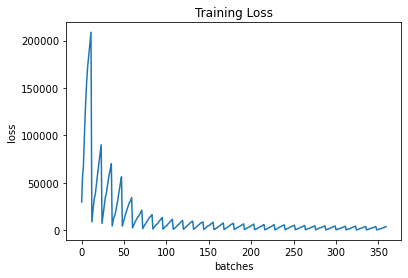

In [160]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("batches")
plt.ylabel("loss")

The training loss spikes each epoch but follows a general downward trend as we would expect.

Text(0.5, 1.0, 'Testing Accuracy')

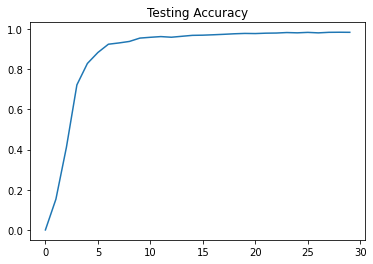

In [159]:
plt.plot(accuracy_history)
plt.title("Testing Accuracy")

The accuracy is similarly unsurprising, with each epoch the accuracy improves with the most significant gains happening early on.
An interesting difference between the accuracy graphs for a classification model and NER model is that the accuracy starts at dead 0 rather than about 25% for classification with 4 classes.

## Validation

To understand how well our model performs it is important to validate it against data it has not been exposed to yet.
We set aside a validation set for exactly this purpose.
We can calculate the accuracy as well as false positives and false negatives on this set.

In [162]:
VALIDATION_DATA = load_list(validate_list)
[total, correct, missed, dne] = accuracy(nlp, VALIDATION_DATA)
print(f"accuracy: {correct}/{total}={correct/total}%, fp {dne}, fn {missed}")

accuracy: 54752/56675=0.9660696956329952%, fp 56769, fn 56675


This results are impressive!
With a dataset we built ourselves were were able to train our model and evaluate it against hundreds of recipes.
We also saved our model so that we can restore it and start building an application on top of it.

Some suggestions we have:
* peek under the hood of spaCy and explore word vectors: what what combinations of ingredients are close in the word vector space?
* build a recipe search engine based on your fridge
* make an app that fills out your shopping list for you

Finally. we can visualize a piece of validation data to sanity check our results.

In [165]:
doc = nlp(VALIDATION_DATA[2][0])

displacy.render(doc, style="ent", options=options)

Sure enough, it seems to mostly be correct!
Here we see a funny mistake, the model misclassified "can" as an ingredient.
This is probably because "can" is used more frequently in recipes to refer to a canned good than in the other sense.

# Acknowledgments

We used the [NER with SpaCy](http://ner.pythonhumanities.com/) textbook extensively in our exploration of SpaCy and much of the model code is based off it.